In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

In [102]:
df= pd.read_csv("/content/MSFT.csv")
df1=df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,83.599998,84.809998,83.220001,84.260002,78.978004,29532100
1,2017-12-04,84.419998,84.430000,80.699997,81.080002,75.997337,39094900
2,2017-12-05,81.339996,82.680000,80.980003,81.589996,76.475357,26152300
3,2017-12-06,81.550003,83.139999,81.430000,82.779999,77.590767,26162100
4,2017-12-07,82.540001,82.800003,82.000000,82.489998,77.318954,23184500
...,...,...,...,...,...,...,...
1386,2023-06-07,331.649994,334.489990,322.500000,323.380005,323.380005,40717100
1387,2023-06-08,323.940002,326.640015,323.350006,325.260010,325.260010,23277700
1388,2023-06-09,324.989990,329.989990,324.410004,326.790009,326.790009,22514900
1389,2023-06-12,328.579987,332.100006,325.160004,331.850006,331.850006,24260300


In [103]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [104]:
# 4. Chia train test
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [105]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [106]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [109]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [110]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [111]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
10/10 [==============================] - 3s 124ms/step - loss: 0.0147 - val_loss: 0.0107
Epoch 2/100
10/10 [==============================] - 1s 78ms/step - loss: 0.0055 - val_loss: 0.0346
Epoch 3/100
10/10 [==============================] - 1s 78ms/step - loss: 0.0022 - val_loss: 0.0248
Epoch 4/100
10/10 [==============================] - 1s 71ms/step - loss: 8.7806e-04 - val_loss: 0.0014
Epoch 5/100
10/10 [==============================] - 1s 69ms/step - loss: 4.1739e-04 - val_loss: 0.0010
Epoch 6/100
10/10 [==============================] - 1s 93ms/step - loss: 2.1741e-04 - val_loss: 9.5337e-04
Epoch 7/100
10/10 [==============================] - 1s 116ms/step - loss: 1.8228e-04 - val_loss: 0.0011
Epoch 8/100
10/10 [==============================] - 1s 117ms/step - loss: 1.8200e-04 - val_loss: 8.6576e-04
Epoch 9/100
10/10 [==============================] - 1s 77ms/step - loss: 1.7016e-04 - val_loss: 6.2904e-04
Epoch 10/100
10/10 [==============================] - 1s 71ms

In [112]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 12ms/step


In [113]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [114]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 266.1702143406726
Testing RMSE: 287.8949428209603


In [116]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=218
n_stepss=75
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_stepss, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.73938105 0.76857616 0.77307944 0.77025537 0.76037102 0.76792733
 0.7941076  0.78594054 0.80460259 0.81055609 0.80765562 0.80235095
 0.79796216 0.78262033 0.75056295 0.74556353 0.74308293 0.75476097
 0.71369693 0.7027822  0.6941572  0.68843266 0.68434913 0.66778616
 0.6570622  0.67553336 0.67717436 0.69984353 0.70820137 0.65225361
 0.65313136 0.62702749 0.62458502 0.62374542 0.61584553 0.60248828
 0.61023549 0.59855744 0.59676375 0.59279476 0.610579   0.59695458
 0.57939931 0.60931959 0.64038474 0.64160595 0.63240851 0.58451327
 0.56546963 0.55081484 0.55211238 0.58451327 0.56283634 0.59706907
 0.60077094 0.59306188 0.59180247 0.61458613 0.63416406 0.64717785
 0.57336952 0.55592874 0.5907339  0.57646076 0.56134796 0.53054999
 0.50822427 0.53547306 0.56020304 0.5640194  0.54738008 0.6178682
 0.63362977 0.61241084 0.6140137  0.61309775 0.61290692 0.61115143
 0.61431901 0.62569174 0.63542347 0.63508001 0.61321224 0.60775488
 0.66427511 0.66255777 0.66381717 0.6454223  0.6260

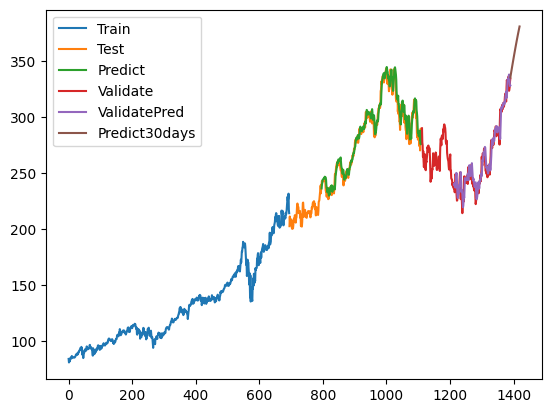

In [117]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()